In [5]:
from dataclasses import dataclass, field, InitVar
from datetime import datetime
from typing import Generator, Tuple

from bs4 import BeautifulSoup
import requests as req

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sns

Valuation = Tuple[np.datetime64, float]


In [6]:

@dataclass
class ETFData:
    id: str
    name: str
    name_CN: str
    invested: float
    units: float  # number of units
    unit_value: float = 0.0
    last_value: float = 0.0
    date_last_value: str = ""
    soup:BeautifulSoup = field(default=None, init=False, repr=False, compare=False)
    refresh:InitVar[bool] = True

    @property
    def total_value(self) -> float:
        """Current total value (i.e. all units)"""
        return float(self.units) * self.unit_value

    @property
    def total_value_last(self) -> float:
        """Current total value (i.e. all units) based on last value"""
        return float(self.units) * self.last_value

    def __post_init__(self, refresh:bool):
        if refresh:
            self.refresh()

    def _get_soup(self, force=False) -> BeautifulSoup:
        """Retrieve Soup with page content from East Money
        
        Args:
            force: Force update of date (default: False)
        """
        if self.soup is None or force:
            resp = req.get(f"http://fund.eastmoney.com/{self.id}.html")
            self.soup = BeautifulSoup(resp.text, 'html.parser')
        return self.soup

    def refresh(self) -> float:
        """"Refresh net values of ETF"""
        soup = self._get_soup()
        self.unit_value = float(soup.find(id="gz_gsz").text)
        self.date_last_value, self.last_value = next(self.last_history())

    def last_history(self) -> Generator[Valuation, None, None]:
        """Get date and values of last unit net value"""
        soup = self._get_soup()
        values_block = soup.find_all(class_="position_shares")[1]
        for line in values_block.find_all("tr")[1:]:
            values = line.find_all("td")
            date, valuation = tuple(v.text for v in values[:2])
            if date.count("-") == 1:
                date = f"{datetime.now().year}-{date}"
            yield np.datetime64(date), float(valuation)

    @property
    def df(self) -> pd.DataFrame:
        """Get Dataframe of a given ETF (without duplicates)"""
        df = pd.read_csv(f"{self.id}.csv", parse_dates=["Date"])[["Date","Unit Net Value"]]
        df["ETF"] = f"{self.id} - {self.name}"
        df.drop_duplicates(subset=["Date"], inplace=True)
        return df

ETFS = [
    ETFData("001668", "Global Mobile","汇添富全球互联",  90_000.0, 47_679.15),
    ETFData("000041",  "Huaxia Global","华夏全球股票",  90_000.0, 87_499.15),
    ETFData("206011", "US Estate", "鹏华美国房地产", 45_000.0, 56_014.10),
]

In [7]:
START_DATE = "2020-04-17"

etf_dfs = [etf.df for etf in ETFS]
# etf_keys = [f"{e.id}-{e.name}" for e in ETFS]
etf_history = pd.concat(etf_dfs)
# etf_keys = [f"{e.id}-{e.name}" for e in ETFS]
etf_history = pd.concat(etf_dfs)

to_plot = etf_history.pivot(index="Date", columns="ETF", values="Unit Net Value").dropna()
to_plot = to_plot[(to_plot != 0.0).all(1)]
to_plot = to_plot / to_plot.loc[START_DATE] * 100
etf_history.tail(20)
to_plot.loc[START_DATE:].tail(20)
# to_plot.dtypes

ETF,000041 - Huaxia Global,001668 - Global Mobile,206011 - US Estate
Date,,,
2020-04-17,100.000000,100.000000,100.000000
2020-04-20,99.707602,99.787121,98.143564
2020-04-21,96.491228,97.605109,97.400990
2020-04-22,99.122807,100.000000,99.133663
2020-04-23,99.025341,99.361362,99.133663
2020-04-24,99.707602,99.414582,99.381188
2020-04-27,100.292398,100.798297,100.990099
2020-04-28,99.122807,100.000000,100.866337
2020-04-29,101.169591,102.448111,100.123762


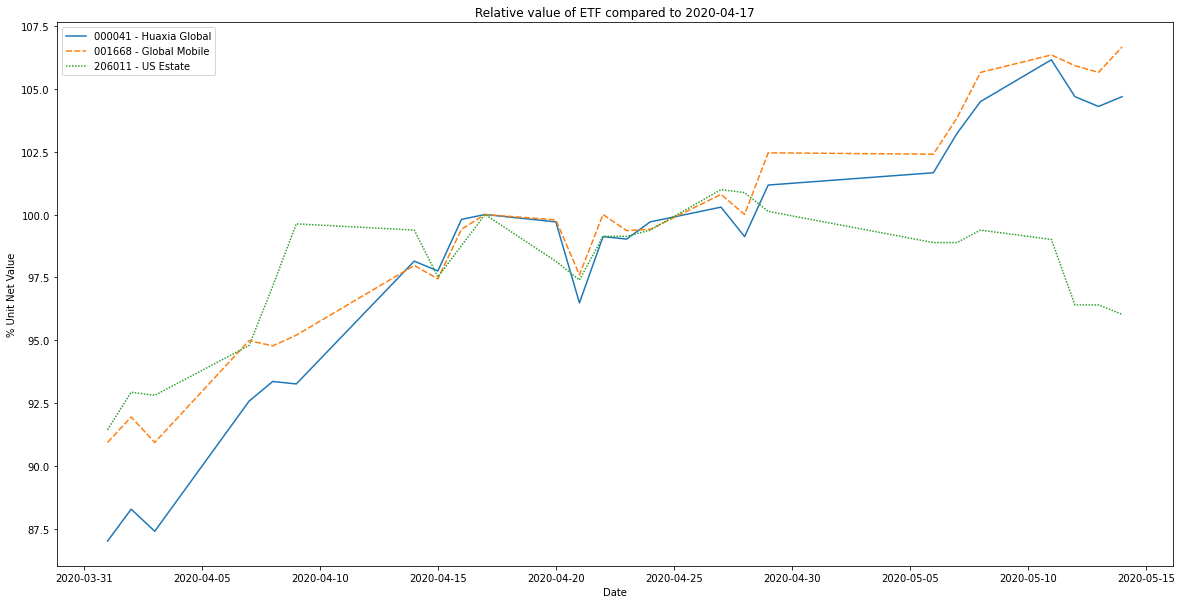

In [8]:
loc = plticker.MultipleLocator(base=3.0) # We want to put a tick every few days 
loc = plticker.MultipleLocator(base=5.0) # We want to put a tick every few days 

plt.figure(figsize=(20, 10))
plt.title(f"Relative value of ETF compared to {START_DATE}")
plt.ylabel("% Unit Net Value")
axes = sns.lineplot(data=to_plot.loc["2020-04-01":])
# axes = sns.lineplot(data=to_plot.loc["2020-04-01":START_DATE])
# axes = sns.lineplot(data=to_plot.loc[START_DATE:])
axes.xaxis.set_major_locator(loc)
# plt.axvline(x=START_DATE)

In [9]:

import altair as alt

def get_relative(df:pd.DataFrame) -> pd.DataFrame:
    """Return DataFrame relative to start value"""
    ref_value = float(df[df["Date"] == START_DATE]["Unit Net Value"])
    df["Relative Net Value"] = df["Unit Net Value"] / ref_value
    return df

etf_relative = [get_relative(df) for df in etf_dfs]
etf_history_relative = pd.concat(etf_relative)
etf_history_relative.head()


data = alt.Chart(etf_history_relative).mark_line().encode(
    alt.X('Date:T'),
    alt.Y('Relative Net Value:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color='ETF',
    strokeDash='ETF',
)

# start_points = pd.DataFrame([{"Date":np.datetime64(START_DATE) , "Ref": 1.0, "ETF": "N/A"}])
start_points = etf_history_relative[etf_history_relative["Date"] == START_DATE]
start_rule = alt.Chart(start_points).mark_rule().encode(
        alt.X('Date:T'),
    alt.Y('Relative Net Value:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color='ETF',
)
alt.layer(data, start_rule).interactive()

ModuleNotFoundError: No module named 'altair'